In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao

In [2]:
from src.agents.bcd_grid import bcd

k_list = [5,50,100]
scale = 0.7
num_iter = 5

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1



In [3]:
k = 100

Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()

bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

fo_values,errors,convs, Q = bcd_inv.bcd_policy_improvement(10,5)

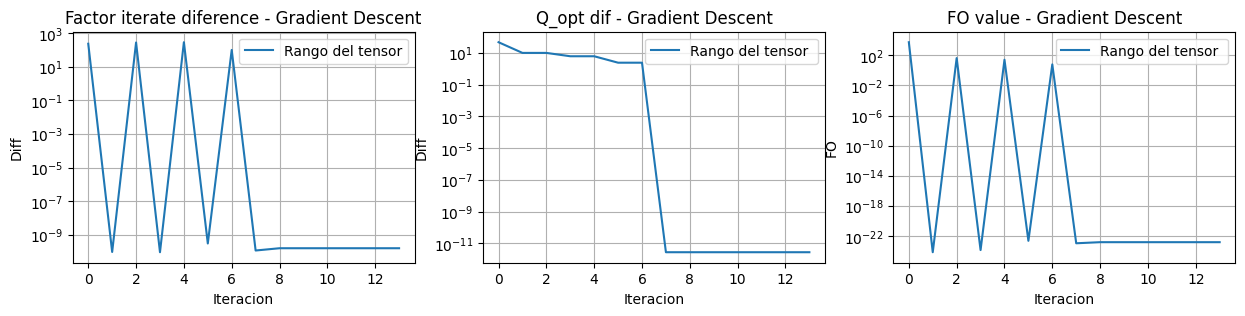

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

# Primer subplot: Seno
axes[0].plot(convs,label = f"Rango del tensor")
axes[0].set_title("Factor iterate diference - Gradient Descent")
axes[0].set_xlabel("Iteracion")
axes[0].set_ylabel("Diff")
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True)

# Segundo subplot: Coseno
axes[1].plot(errors,label = f"Rango del tensor ")
axes[1].set_title("Q_opt dif - Gradient Descent")
axes[1].set_xlabel("Iteracion")
axes[1].set_ylabel("Diff")
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

# Tercer subplot: Tangente
axes[2].plot(fo_values ,label = f"Rango del tensor ")
axes[2].set_title("FO value - Gradient Descent")
axes[2].set_xlabel("Iteracion")
axes[2].set_ylabel("FO")
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True)


In [2]:
from src.agents.bcd_grid import bcgd

# GridWorld
k_list = [20, 50, 100]
scale = 0.5
num_iter = 1500
alpha = 10e-4
use_q_qopt = False

ENV = GridWorldEnv()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

if use_q_qopt == True:
    new_values = parafac(Q_opt, rank=k)[1]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización direct
        i = 0
        for i in range(len(new_values)):
            shape = new_values[i].shape
            new_values[i] = new_values[i] + np.random.rand(*shape)*0.0001
            
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(torch.tensor(new_value))  # Copiar los nuevos valores al parámetro existente

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

In [9]:
k = 100

Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()

bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,5,5,ENV.nA),alpha)

fo_values,errors,convs, Q = bcd_grad.bcgd_policy_improvement(1000,50)

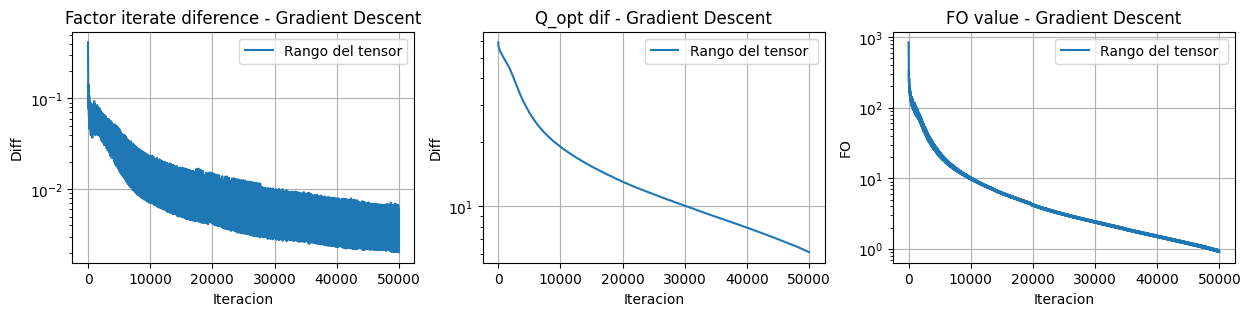

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

# Primer subplot: Seno
axes[0].plot(convs,label = f"Rango del tensor")
axes[0].set_title("Factor iterate diference - Gradient Descent")
axes[0].set_xlabel("Iteracion")
axes[0].set_ylabel("Diff")
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True)

# Segundo subplot: Coseno
axes[1].plot(errors,label = f"Rango del tensor ")
axes[1].set_title("Q_opt dif - Gradient Descent")
axes[1].set_xlabel("Iteracion")
axes[1].set_ylabel("Diff")
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

# Tercer subplot: Tangente
axes[2].plot(fo_values ,label = f"Rango del tensor ")
axes[2].set_title("FO value - Gradient Descent")
axes[2].set_xlabel("Iteracion")
axes[2].set_ylabel("FO")
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True)